In [2]:
import hoomd

import hoomd.pair_plugin.pair as ppair

from monk import prep, pair

import ex_render

import numpy as np

In [3]:
N = 512
D = 2
phi_initial = 0.2
phi_final = 1.0
L = prep.len_from_phi(N, phi_initial, dim=D)
L_final = prep.len_from_phi(N, phi_final, dim=D)

In [93]:
device = hoomd.device.auto_select()
sim = hoomd.Simulation(device, seed=1234)

rng = prep.init_rng(123)
snap = prep.approx_euclidean_snapshot(N, L, rng, dim=D, particle_types=["A"], ratios=[100], diams=[1.0])
snap.particles.moment_inertia = N*[[1, 1, 1]]

sim.create_state_from_snapshot(snap)

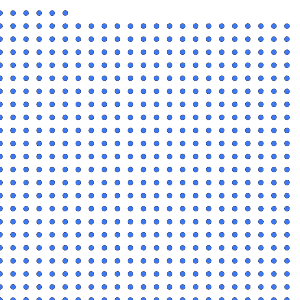

In [94]:
ex_render.render_disk_frame(frame=sim.state.get_snapshot())

In [95]:
# thermalize the system

integrator = hoomd.md.Integrator(dt=0.0025, integrate_rotational_dof=False)
nvt = hoomd.md.methods.NVT(hoomd.filter.All(), 1.0, 0.25)
tree = hoomd.md.nlist.Tree(0.3)
# flj = ppair.FrictionLJ(tree, default_r_cut=2.5, mode="shift")
# flj.params[('A', 'A')] = dict(epsilon=1.0, aes=1.0, sigma=1.0, delta=0.0, mus=0.0, mur=np.inf, ks=0.0, kr=10.0)

flj = hoomd.md.pair.LJ(tree, default_r_cut=2.5)
flj.params[('A', 'A')] = dict(epsilon=1.0, sigma=1.0)


integrator.forces = [flj]
integrator.methods = [nvt]

sim.operations.integrator = integrator

In [96]:
sim.run(0)

nvt.thermalize_thermostat_dof()

sim.run(40_000)

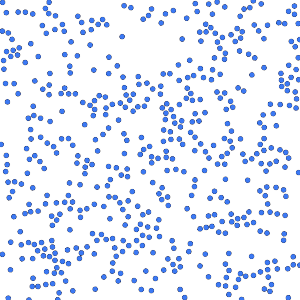

In [97]:
ex_render.render_disk_frame(frame=sim.state.get_snapshot())

In [98]:
hoomd.write.GSD.write(sim.state, "friction_test.gsd")

In [36]:
ramp = hoomd.variant.Ramp(0.0, 1.0, sim.timestep, 4000)
initial_box = sim.state.box
final_box = hoomd.Box(Lx=L_final, Ly=L_final)
box_resize = hoomd.update.BoxResize(hoomd.trigger.Periodic(10), initial_box, final_box, ramp)

sim.operations.updaters.append(box_resize)

sim.run(4000)

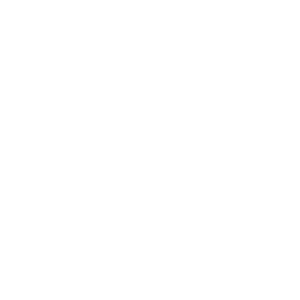

In [37]:
ex_render.render_disk_frame(frame=sim.state.get_snapshot())

In [4]:
device = hoomd.device.auto_select()
sim = hoomd.Simulation(device, seed=1234)

sim.create_state_from_gsd("test5.gsd", 0)

In [5]:
# thermalize the system

# integrator = hoomd.md.minimize.FIRE(
#     dt=0.0025,
#     force_tol=1e-3,
#     angmom_tol=1e-3,
#     energy_tol=1e-3,
#     integrate_rotational_dof=False)
integrator = hoomd.md.Integrator(dt=0.0025, integrate_rotational_dof=False)
nvt = hoomd.md.methods.NPT(hoomd.filter.All(), 0.1, 0.25, 0.05, 1.0, couple="xyz", gamma=0.01)
tree = hoomd.md.nlist.Tree(0.2)
# flj = ppair.FrictionLJ(tree, default_r_cut=2.5, mode="shift")
# flj.params[('A', 'A')] = dict(epsilon=1.0, aes=0.0, sigma=1.0, delta=0.0, mus=0.2, mur=0.2, ks=10.0, kr=10.0)

flj = hoomd.md.pair.LJ(tree, default_r_cut=2.0**(1/6))
flj.params[('A', 'A')] = dict(epsilon=1.0, sigma=1.0)


integrator.forces = [flj]
integrator.methods = [nvt]

sim.operations.integrator = integrator

writer = hoomd.write.GSD(trigger=hoomd.trigger.Periodic(400), filename="test5.gsd", mode="wb", filter=hoomd.filter.All())
sim.operations.writers.clear()
sim.operations.writers.append(writer)


sim.run(0)

# nvt.thermalize_thermostat_and_barostat_dof()

ramp = hoomd.variant.Ramp(0.0, 1.0, sim.timestep, 400)
fL = prep.len_from_phi(N, 0.8, dim=D)
initial_box = sim.state.box
final_box = hoomd.Box(Lx=L_final, Ly=L_final)
box_resize = hoomd.update.BoxResize(hoomd.trigger.Periodic(10), initial_box, final_box, ramp)

# sim.operations.updaters.append(box_resize)

sim.run(400)

In [6]:
sim.run(40_000)
# ex_render.render_sphere_frame(frame=sim.state.get_snapshot())

In [7]:
# thermalize the system

# integrator = hoomd.md.minimize.FIRE(
#     dt=0.0025,
#     force_tol=1e-3,
#     angmom_tol=1e-3,
#     energy_tol=1e-3,
#     integrate_rotational_dof=False)
integrator = hoomd.md.Integrator(dt=0.0025, integrate_rotational_dof=False)
nvt = hoomd.md.methods.NVE(hoomd.filter.All())
tree = hoomd.md.nlist.Tree(0.2)
# flj = ppair.FrictionLJ(tree, default_r_cut=2.5, mode="shift")
# flj.params[('A', 'A')] = dict(epsilon=1.0, aes=0.0, sigma=1.0, delta=0.0, mus=0.2, mur=0.2, ks=10.0, kr=10.0)

flj = hoomd.md.pair.LJ(tree, default_r_cut=2.0**(1/6))
flj.params[('A', 'A')] = dict(epsilon=1.0, sigma=1.0)


integrator.forces = [flj]
integrator.methods = [nvt]

sim.operations.integrator = integrator

writer = hoomd.write.GSD(trigger=hoomd.trigger.Periodic(400), filename="test6.gsd", mode="wb", filter=hoomd.filter.All())
sim.operations.writers.clear()
sim.operations.writers.append(writer)


sim.run(0)

# nvt.thermalize_thermostat_and_barostat_dof()

In [8]:
# const integrated flow with 0.1 slope for max 1e8 timesteps
ramp = hoomd.variant.Ramp(0.0, 0.0025*0.1e8, sim.timestep, int(1e8))
# velocity gradient in z direction and shear flow in x direction.
mpf = hoomd.md.update.ReversePerturbationFlow(
    filter=hoomd.filter.All(),
    flow_target=ramp,
    slab_direction="Z",
    flow_direction="X",
    n_slabs=10
)

sim.operations.updaters.append(mpf)

In [9]:
sim.run(0)

In [11]:
mpf.

49.67547692951423

In [10]:
sim.run(4_000)

*Warning*:  After 100 MuellerPlatheFlow could not achieve the target: 0.127 only 0.116577 could be achieved.
*Warning*:  After 100 MuellerPlatheFlow could not achieve the target: 0.12725 only 0.116577 could be achieved.
*Warning*:  After 100 MuellerPlatheFlow could not achieve the target: 0.1275 only 0.116577 could be achieved.
*Warning*:  After 100 MuellerPlatheFlow could not achieve the target: 0.12775 only 0.116577 could be achieved.
*Warning*:  After 100 MuellerPlatheFlow could not achieve the target: 0.128 only 0.116577 could be achieved.
*Warning*:  After 100 MuellerPlatheFlow could not achieve the target: 0.12825 only 0.116577 could be achieved.
*Warning*:  After 100 MuellerPlatheFlow could not achieve the target: 0.1285 only 0.116577 could be achieved.
*Warning*:  After 100 MuellerPlatheFlow could not achieve the target: 0.12875 only 0.116577 could be achieved.
*Warning*:  After 100 MuellerPlatheFlow could not achieve the target: 0.129 only 0.116577 could be achieved.
*Warning*

In [48]:
sim.state.get_snapshot().particles.position

array([[ 17.42263222,  25.15672112,   0.        ],
       [-13.52286243,  14.12936115,   0.        ],
       [-14.83320141,   6.51877165,   0.        ],
       ...,
       [  7.95228863,  23.35511017,   0.        ],
       [ -2.99411917,  -7.02119493,   0.        ],
       [-15.54184818, -25.26693535,   0.        ]])